In [13]:
import os, json
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
from sklearn.linear_model import LinearRegression
#from sklearn.linear_model import LogisticRegression
import matplotlib.dates as dates
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

class Analyse:
    def startAnalyse(df, countries, yLabel, yColumn):
        df = df[(df["Value"]>0)] #suppress data with no cases (before begin of epidemy)
        X = {}
        convertedX = {}
        y = {}
        y_log = {}
        regressor = {}
        model = {}
        r_sq = {}
        X_pred = {}
        y_pred = {}
        
        coeff = {}
        dailyCoeff = {}

        for country in countries:
            # Select data
            X[country] = df[df["Country/Region"]==country][["update"]].copy()
            convertedX[country] = X[country].copy()
            convertedX[country]["update"] = convertedX[country]["update"].astype(int)
            ## for backwards conversion to datetime: pd.to_datetime(X["update"].astype(int))
            y[country] = df[df["Country/Region"]==country][yColumn]
            y_log[country] = np.log(df[df["Country/Region"]==country][yColumn])
            # Create model
            regressor[country] = LinearRegression()
            model[country] = regressor[country].fit(convertedX[country], y_log[country])
            r_sq[country] = model[country].score(convertedX[country], y_log[country])
            coeff[country] = regressor[country].coef_[0]
            dailyCoeff[country] = round(10**(3600*24*(10**9)*regressor[country].coef_[0]), 1)
            #print(country)
            #print('intercept:', model[country].intercept_)
            #print('slope:', model[country].coef_[0])

            # Generate prediction: regressor.predict(convertedX)
            X_pred[country] = pd.DataFrame([
                X[country].min(), 
                X[country].min() + pd.Timedelta(1, unit='d'), 
                X[country].min() + pd.Timedelta(2, unit='d'), 
                X[country].min() + pd.Timedelta(3, unit='d'), 
                X[country].min() + pd.Timedelta(4, unit='d'), 
                X[country].min() + pd.Timedelta(5, unit='d'), 
                X[country].min() + pd.Timedelta(6, unit='d'), 
                X[country].min() + pd.Timedelta(7, unit='d'), 
                X[country].max() + pd.Timedelta(14, unit='d')])
            y_pred[country] = np.exp(regressor[country].predict(X_pred[country].astype(int)))
        # Plot result
        fig, ax = plt.subplots(ncols=1, nrows=1)
        ax.set_yscale("log")
        #ax.set_ylim(1,10000)

        ax.grid(True, which="minor", axis="y", color='g', linestyle='--', linewidth=1)
        ax.grid(True, which="major", axis="y", color='g', linestyle='-', linewidth=2)

        ax.xaxis.set_minor_locator(dates.DayLocator(bymonthday=range(1,32), interval=1))
        ax.xaxis.set_minor_formatter(dates.DateFormatter('%d'))
        ax.xaxis.set_major_locator(dates.WeekdayLocator(byweekday=0))
        ax.xaxis.set_major_formatter(dates.DateFormatter('\n%m-%d'))
        ax.grid(True, which="major", axis="x", color='g', linestyle='-', linewidth=2)
        fig.set_size_inches(20,5)
        for country in countries:
            plotDf = pd.DataFrame(X[country])
            plotDf["y"]=y[country]
            plotDf.plot(x="update", y="y", ax=ax, style="o:", label="act "+country)
            
            plotDf_pred = pd.DataFrame(X_pred[country])
            plotDf_pred["y"]=y_pred[country]
            plotDf_pred.plot(x="update", y="y", ax=ax, style="--", label="pred "+country)
            #plt.plot(X[country], y[country], "ro")
            #plt.plot(X_pred[country][["update"]], y_pred[country], "b--")
        plt.title('prediction')
        plt.xlabel('datetime')
        plt.ylabel(yLabel)
        plt.show()

        print('Coefficient of determination:', r_sq)
        print("Evolution factor per day: {}".format(dailyCoeff))
        #print("Evolution factor per 2 days: {}".format(round(10**(3600*24*2*(10**9)*regressor[country].coef_[0]), 1)))
        #print("Evolution factor per 3 days: {}".format(round(10**(3600*24*3*(10**9)*regressor[country].coef_[0]), 1)))
        #print("Evolution factor per week: {}".format(round(10**(3600*24*7*(10**9)*regressor[country].coef_[0]), 1)))

        X_pred[country]["pred"] = pd.DataFrame(y_pred[country])
        X_pred[country]["prev"] = X_pred[country].apply(
            lambda row: X_pred[country][X_pred[country]["update"]<row["update"]]["update"].max(), 
            axis=1
        )
        X_pred[country]["diff"] = X_pred[country].apply(
            lambda row: row["pred"] / X_pred[country][X_pred[country]["update"]==row["prev"]]["pred"].max(), 
            axis=1
        )
        return X_pred

In [14]:
import requests
import io

# Load data from url
def loadData(url):
    urlData = requests.get(url).content
    return pd.read_csv(io.StringIO(urlData.decode('utf-8')))
# Pivoting
def Pivot(df):
    # Exclude outside Europe
    df = df[
        (df["Lat"]>40) & (df["Lat"]<55)
        & (df["Long"]>0) & (df["Long"]<27)
    ]
    df = df.set_index(["Province/State", "Country/Region","Lat","Long"])
    df = df.stack().reset_index().rename(
        columns={"level_4":"Date",0:"Value"}
    )
    df["update"] = pd.to_datetime(df["Date"])
    maxDate = df["update"].max()
    df = df[
        (df["update"]>maxDate - pd.Timedelta(days=60))
    ]
    return df[df["Value"]>0][["Country/Region","update","Value"]]

# Configuration and load of base data

In [15]:
base_url = "https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/"
confirmedUrl = "time_series_19-covid-Confirmed.csv"
deathsUrl = "time_series_19-covid-Deaths.csv"
recoveredUrl = "time_series_19-covid-Recovered.csv"

countriesSelected = ["Italy","France","Germany"]

In [16]:
confirmedDf = loadData(base_url+confirmedUrl)
deathsDf = loadData(base_url+deathsUrl)
recoveredDf = loadData(base_url+recoveredUrl)

# Start of Analysis

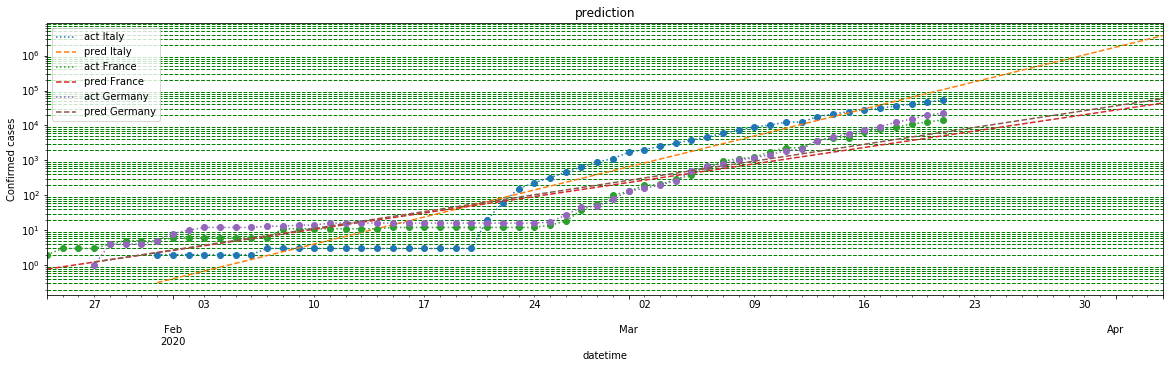

Coefficient of determination: {'Italy': 0.9277078622071253, 'France': 0.8785059427162796, 'Germany': 0.8777177210364107}
Evolution factor per day: {'Italy': 1.8, 'France': 1.4, 'Germany': 1.4}


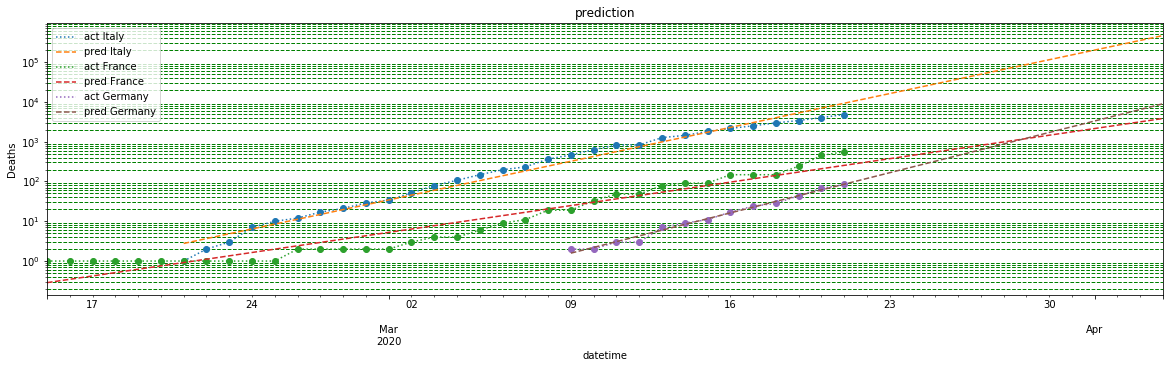

Coefficient of determination: {'Italy': 0.9782559086846383, 'France': 0.9265542428465746, 'Germany': 0.9875038291316265}
Evolution factor per day: {'Italy': 1.9, 'France': 1.6, 'Germany': 2.2}


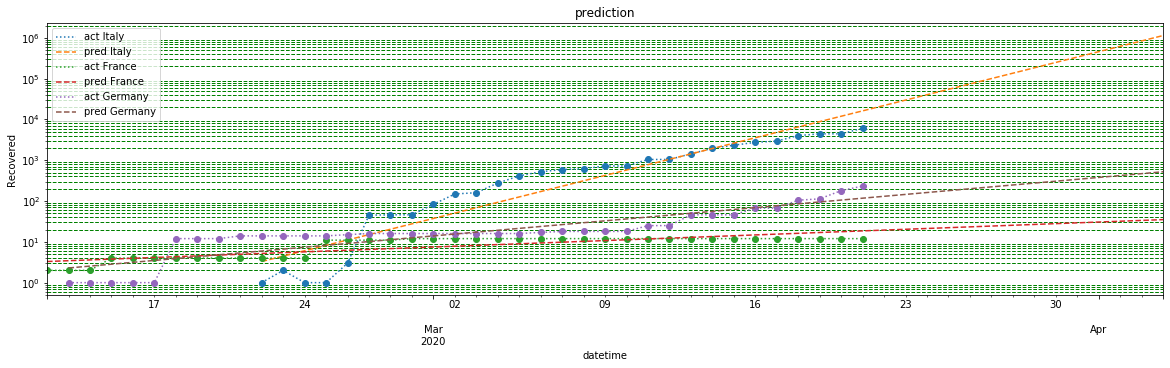

Coefficient of determination: {'Italy': 0.8834556407949635, 'France': 0.7011579010434751, 'Germany': 0.7724157012173138}
Evolution factor per day: {'Italy': 2.0, 'France': 1.1, 'Germany': 1.3}


In [17]:
tmpDf = Analyse.startAnalyse(
    Pivot(confirmedDf),
    countriesSelected,
    "Confirmed cases", 
    "Value"
)
tmpDf = Analyse.startAnalyse(
    Pivot(deathsDf),
    countriesSelected,
    "Deaths", 
    "Value"
)
tmpDf = Analyse.startAnalyse(
    Pivot(recoveredDf),
    countriesSelected,
    "Recovered", 
    "Value"
)

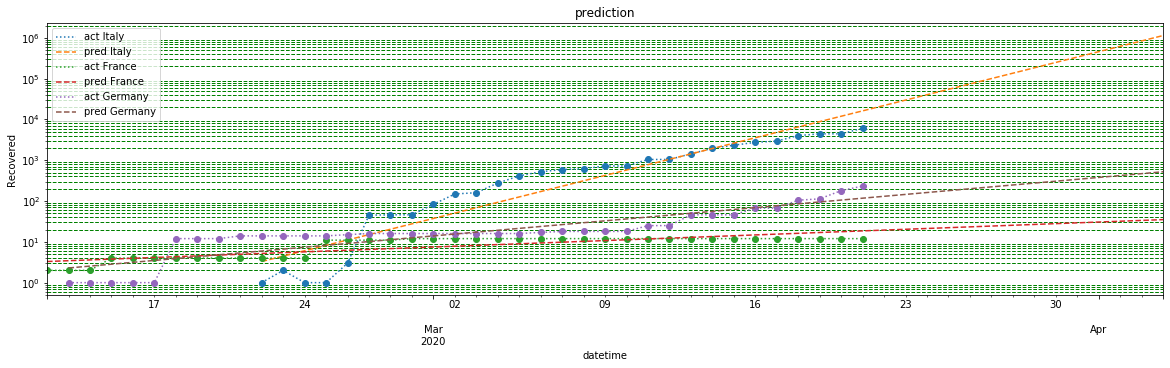

Coefficient of determination: {'Italy': 0.8834556407949635, 'France': 0.7011579010434751, 'Germany': 0.7724157012173138}
Evolution factor per day: {'Italy': 2.0, 'France': 1.1, 'Germany': 1.3}


In [18]:
tmpDf = Analyse.startAnalyse(
    Pivot(recoveredDf),
    countriesSelected,
    "Recovered", 
    "Value"
)